In [1]:
from __future__ import division

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
sns.set_palette("colorblind")

%matplotlib inline

import datagenerators as dg

In [2]:
import warnings
warnings.filterwarnings('ignore')

In this post, I will be using the excellent [`CausalInference`](http://causalinferenceinpython.org/) package to give an overview of how we can use the [potential outcomes](https://en.wikipedia.org/wiki/Rubin_causal_model) framework to try and make causal inferences about situations where we only have observational data. The author has a good series of [blog posts](http://laurence-wong.com/software/) on it's functionality.

この投稿では、優れた[`CausalInference`](http://causalinferenceinpython.org/)パッケージを使用して、観測データしかない状況について因果関係を推論しようとするフレームワーク[`ポテンシャル・アウトカム`](https://en.wikipedia.org/wiki/Rubin_causal_model)の使用方法の概要を説明します。著者は、その機能に関する一連の[ブログ投稿](http://laurence-wong.com/software/)を書いています。

Because most datasets you can download are static, throughout this post I will be using be using my own functions to generate data. This has two advantages: we can and will generate datasets with specific properties, and we have the ability to "intervene" in the data generating system directly, giving us the ability to check whether our inferences are correct. These data generators all generate [i.i.d.](https://en.wikipedia.org/wiki/Independent_and_identically_distributed_random_variables) samples from some distribution, returning the results as a pandas dataframe. You can find the functions which generate these datasets in the accompanying file `datagenerators.py` on github [here](https://github.com/ijmbarr/notes-on-causal-inference).

ダウンロードできるほとんどのデータセットは静的であるため、この投稿では、自分の関数を使用してデータを生成します。 これには2つの利点があります。特定のプロパティを持つデータセットを生成できること、および生成すること、そしてデータ生成システムに直接「介入」して、推論が正しいかどうかをチェックできることです。 これらのデータジェネレーターはすべて、いくつかの分布から[i.i.d.](https://en.wikipedia.org/wiki/Independent_and_identically_distributed_random_variables)サンプルを生成し、結果をpandasデータフレームとして返します。 これらのデータセットを生成する関数は、github [ここ](https://github.com/ijmbarr/notes-on-causal-inference)の添付ファイル `datagenerators.py`にあります。

To begin, let's look at a motivating example.

まずは、やる気の出る例を見てみましょう。

# Introduction
# 導入

One day a team lead notices that some members of their team wear cool hats, and that these members of the team tend to be less productive. Being data drive, the Team Lead starts to record whether or not a team member wears a cool hat ($X=1$ for a cool hat, $X=0$ for no cool hat) and whether or not they are productive ($Y=1$ for productive, $Y=0$ for unproductive).

ある日、チームのリーダーが、チームの一部のメンバーがかっこいい帽子をかぶっていて、チームのこれらのメンバーの生産性が低下する傾向にあることに気付きました。 チームリーダーはデータに基づいて、チームメンバーがクールハットを着用しているかどうか（クールハットの場合は$X=1$、クールハットでない場合は$X=0$）、および生産的かどうか（$Y=1$は生産的、$Y=0$は非生産的）を記録し始めます。

After making observations for a week, they end up with a dataset like the following:

1週間観察した結果、チームは次のようなデータセットを得ました。

In [3]:
observed_data_0 = dg.generate_dataset_0()

observed_data_0.head()

,x,y
0,0,0
1,1,1
2,0,0
3,0,1
4,0,0


The first question the team lead asks is: are people wearing cool hats more likely to be productive that those who don't? This means estimating the quantity

チームリーダーが最初に尋ねる質問は「クールな帽子をかぶった人は、そうでない人よりも生産的である可能性が高いですか？」です。これは以下の数量を推定することを意味します

$P(Y=1|X=1) - (Y=1|X=0)$

which we can do directly from the data:

そして直接データから推定することができます:

In [4]:
def estimate_uplift(ds):
    """
    Estiamte the difference in means between two groups.
    
    Parameters
    ----------
    ds: pandas.DataFrame
        a dataframe of samples.
        
    Returns
    -------
    estimated_uplift: dict[Str: float] containing two items:
        "estimated_effect" - the difference in mean values of $y$ for treated and untreated samples.
        "standard_error" - 90% confidence intervals arround "estimated_effect"
        
        
    """
    base = ds[ds.x == 0]
    variant = ds[ds.x == 1]
    
    delta = variant.y.mean() - base.y.mean()
    delta_err = 1.96 * np.sqrt(
        variant.y.var() / variant.shape[0] + 
        base.y.var() / base.shape[0])
    
    return {"estimated_effect": delta, "standard_error": delta_err}

estimate_uplift(observed_data_0)

{'estimated_effect': -0.15738429037833684,
 'standard_error': 0.08639322378194732}

It looks like people with cool hats are less productive. 

クールな帽子をかぶった人は生産性が低いようです。

To be sure, we can even run a statistical test:

確かめるために、統計的検定を実行することもできます。

In [5]:
from scipy.stats import chi2_contingency

contingency_table = (
    observed_data_0
    .assign(placeholder=1)
    .pivot_table(index="x", columns="y", values="placeholder", aggfunc="sum")
    .values
)

_, p, _, _ = chi2_contingency(contingency_table, lambda_="log-likelihood")

# p-value
p

0.0005626147113456373

That's one small p-value. [Staticians would be proud](https://www.nature.com/articles/s41562-017-0189-z).

これは1つの小さなp値です。[統計家は誇りに思うでしょう](https://www.nature.com/articles/s41562-017-0189-z)

We can use this information to make statements about what we might think about someone's probability if we see them wearing a cool hat. As long as we believe that they are "drawn from the same distribution" as our previous observations, we expect the same correlations to exist. 

この情報を使用して、クールな帽子をかぶっている人がいる場合、その人の確率についてどのように考えるかについて説明できます。以前の観察と「同じ分布から引き出されている」と私たちが信じている限り、同じ相関関係が存在すると予想されます。

The problem comes if we try to use this information as an argument about whether or not the team lead should **force** people to wear cool hats. If the team lead does this they fundamentally change the system we are sampling from, potentially altering or even reversing any correlations we observed before.

問題は、チームリーダーが人々にクールな帽子をかぶらせるかどうかについての議論としてこの情報を使用しようとする場合です。チームリーダーがこれを行うと、サンプリング元のシステムが根本的に変更され、以前に観察された相関関係が変更または逆転される可能性もあります。

The cleanest way to actually measure the effect of some change in a system is by running a [randomized control trial](https://en.wikipedia.org/wiki/Randomized_controlled_trial). Specifically, we want to randomize who gets cool hats and who doesn't, and look at the different values of $y$ we receive. This removes the effect of any [confounding variables](https://en.wikipedia.org/wiki/Confounding) which might be influencing the metric we care about.

システムの一部の変更の影響を実際に測定する最もクリーンな方法は、[ランダム化比較試験](https://en.wikipedia.org/wiki/Randomized_controlled_trial) を実行することです。具体的には、誰がクールな帽子を手に入れ、誰がそうしないかをランダム化し、得られる値 $y$ の違いを見ます。これにより、気になる指標に影響を及ぼしている可能性のある[交絡変数](https://en.wikipedia.org/wiki/Confounding) の影響が除去されます。


Because we generated our dataset from a known process (in this case a function I wrote), we can intervene in it directly and measure the effect of an A/B test:

既知のプロセス（この場合は私が作成した関数）からデータセットを生成したので、それに直接介入してA / Bテストの効果を測定できます。

In [6]:
def run_ab_test(datagenerator, n_samples=10000, filter_=None):
    """
    Generates n_samples from datagenerator with the value of X randomized
    so that 50% of the samples recieve treatment X=1 and 50% receive X=0,
    and feeds the results into `estimate_uplift` to get an unbiased 
    estimate of the average treatment effect.
    
    Returns
    -------
    effect: dict
    """
    n_samples_a = int(n_samples / 2)
    n_samples_b = n_samples - n_samples_a
    set_X = np.concatenate([np.ones(n_samples_a), np.zeros(n_samples_b)]).astype(np.int64)
    ds = datagenerator(n_samples=n_samples, set_X=set_X)
    if filter_ != None:
        ds = ds[filter_(ds)].copy()
    return estimate_uplift(ds)

run_ab_test(dg.generate_dataset_0)

{'estimated_effect': 0.18679999999999997,
 'standard_error': 0.019256613018207393}

Suddenly, it looks like the direction of the effect of wearing cool hats has reversed. 

What's going on?

突然、かっこいい帽子をかぶる効果の方向性が逆転したようです。

何が起こっているのでしょうか？

Note: In the above example, and in all following examples, I'm assuming that our samples are [i.i.d.](https://en.wikipedia.org/wiki/Independent_and_identically_distributed_random_variables), and obey the [Stable unit treatment value assumption (SUTVA)](https://en.wikipedia.org/wiki/Rubin_causal_model#Stable_unit_treatment_value_assumption_%28SUTVA%29). Basically this means that when one person chooses, or is forced to wear a really cool hat they have no influence on the choice or effect of another person wearing a really cool hat. By construction, the synthetic datagenerators I use all have this property. In reality it is yet another thing you have to assume to be true.

注意：上記の例とこれに続く全ての例で、標本は[i.i.d](https://en.wikipedia.org/wiki/Independent_and_identically_distributed_random_variables) で、[SUTVA](https://en.wikipedia.org/wiki/Rubin_causal_model#Stable_unit_treatment_value_assumption_%28SUTVA%29) に従っていることを想定しています。基本的に、これは、ある人が本当にクールな帽子を選択する、または着用を強いられた場合、他の人が本当にクールな帽子を着用することの選択または影響に影響を与えないことを意味します。 構造上、私が使用するすべての合成データジェネレーターはこの特性を持っています。 現実では、それはあなたが真実であると仮定しなければならないまた別のことです。

# Definitions of Causality 
# 因果関係の定義

The previous example demonstrates the old statistics saying: 

[**Correlation Does Not Imply Causation**](https://xkcd.com/552/).

先の例は、昔の統計家の格言を示しています: 

[**相関関係は因果関係を意味しない**](https://xkcd.com/552/)



["Causality"](https://plato.stanford.edu/entries/causation-metaphysics/) is a vague, philosophical sounding word. In the current context, I am using it to mean "What is the effect on $Y$ of changing $X$?"


["因果関係"](https://plato.stanford.edu/entries/causation-metaphysics/)は、漠然とした哲学的に響く単語です。 現在の文脈では、「 $X$ の変更が $Y$ に及ぼす影響は何ですか」という意味で使用しています。

To be precise, $X$ and $Y$ are [random variables](http://mathworld.wolfram.com/RandomVariable.html) and the "effect" we want to know is how the distribution of $Y$ will change when we force $X$ to take a certain value. This act of forcing a variable to take a certain value is called an "Intervention".

正確には、$X$ と $Y$ は[ランダム変数](http://mathworld.wolfram.com/RandomVariable.html) であり、知りたい「効果」は、$X$ に特定の値を代入すると $Y$ の分布がどのように変化するかです。 変数に特定の値を強制的に与えるこの行為は、「介入」と呼ばれます。

In the previous example, when we make no intervention on the system, we have an observational distribution of $Y$, conditioned on the fact we observe $X$:

先ほどの例では、システムに何も介入しなかった場合、 $X$ を観測したことを条件に、 $Y$ の観測分布が得られます。


$P(Y|X)$

When we force people to wear cool hats, we are making an intervention. The distribution of $Y$ is then given by the _interventional_ distribution 

私たちが人々にかっこいい帽子を強制するとき、私たちは介入をしています。そして、$Y$の分布は、_介入_ 分布によって与えられます。

$P(Y|\hbox{do}(X))$

In general these two are not the same.

一般的には、この二つは同じではありません。


The question these notes will try and answer is how we can reason about the interventional distribution, when we only have access to observational data. This is a useful question because there are lots of situations where running an A/B test to directly measure the effects of an intervention is impractical, unfeasable or unethical. In these situations we still want to be able to say something about what the effect of an intervention is - to do this we need to make some assumptions about the data generating process we are investigating.

これらのノートが試みて答えようとする質問は、観察データしか入手できない場合に、どのようにして介入分布について推論できるかということです。介入の効果を直接測定するためにA/Bテストを実行することが非現実的、実現不可能、または非倫理的な状況がたくさんあるので、これは有用な質問です。このような状況でも、介入の効果が何であるかについて何かを言えるようにしたいと思います。

# Potential Outcomes
# ポテンシャル・アウトカム

One way to approach this problem is to introduce two new random variables to our system: $Y_{0}$ and $Y_{1}$, known as the [Potential Outcomes](http://www.stat.unipg.it/stanghellini/rubinjasa2005.pdf). We imagine that these variables exist, and can be treated as any other random variable - the only difference is that they are never directly observed.

この問題にアプローチする1つの方法は、2つの新しいランダム変数をシステムに導入することです： $Y_{0}$ と $Y_{1}$ で、[ポテンシャル・アウトカム](http://www.stat.unipg.it/stanghellini/rubinjasa2005.pdf)として知られています。これらの変数は存在し、他のランダム変数と同じように扱うことができると仮定します。

 $Y$ is defined in terms of 
 $Y$ は、次のように定義されています。


 - $Y = Y_{1}$ when $X=1$
 - $Y = Y_{0}$ when $X=0$
 
This shifts the problem from one about how distributions change under the intervention, to one about data drawn i.i.d. from some underlying distribution with [missing values](https://en.wikipedia.org/wiki/Missing_data). Under certain assumptions about why values are missing, there is well developed theory about how to estimate the missing values.


これは、問題を介入の下で分布がどのように変化するかについてのものから、[欠損値](https://en.wikipedia.org/wiki/Missing_data)を持ついくつかの基礎となる分布からi.i.d.で描かれたデータについてのものへとシフトさせます。なぜ値が欠損しているのかについてのある仮定の下では、欠損値を推定する方法についてはよく発展した理論があります。


# Goals
# 目標

Often we do not care about the full interventional distribution, $P(Y|\hbox{do}(X))$, and it is enough to have an estimate of the difference in means between the two groups. This is a quantity known as the [Average Treatment Effect](https://en.wikipedia.org/wiki/Average_treatment_effect):


しばしば、我々は完全な介入分布、$P(Y|\hbox{do}(X))$を気にしません、そして、2つのグループ間の平均の差の推定値があれば十分です。これは、[平均処置効果(ATE)](https://en.wikipedia.org/wiki/Average_treatment_effect)として知られている量です。

$\Delta = E[Y_{1} - Y_{0}]$

When we run and A/B test and compare the means of each group, this is directly the quantity we are measuring


A/Bテストを実行し、各グループの平均値を比較するとき、これは私たちが測定している量に直結しています。


If we just try and estimate this quantity from the observational distribution, we get:


この量を観測分布から推定してみると、以下のものが得られます。

$\Delta_{bad} = E[Y|X=1] - E[Y|X=0] \\
= E[Y_{1}|X=1] - E[Y_{0}|X=0] \\
\neq \Delta$

This is not generally equal to the true ATE because:

これは、一般的には真のATEとは一致しません。なぜならば

$E[Y_{i}|X=i] \neq E[Y_{i}]$

Two related quantities are

関連する2つの量は 

 - $ATT = E[Y_{1} - Y_{0}|X=1]$, the "Average Treatment effect of the Treated"
 - $ATC = E[Y_{1} - Y_{0}|X=0]$, the "Average Treatment effect of the Control"

One way to interpret ATC is as a measure of the effect of treating only samples which wouldn't naturally be treated, and vice versa for ATT. Depending on your use case, they may be more natural measures of what you care about. The following techniques will allow us to estimate them all. 

ATCを解釈する一つの方法は、自然には処理されないサンプルのみを処理した場合の効果を測定するものであり、ATTの場合はその逆です。使用ケースにもよりますが、それらはあなたが気にしていることのより自然な尺度になるかもしれません。以下のテクニックを使えば、それらをすべて推定することができます。

$\def\ci{\perp\!\!\!\perp}$
# Making Assumptions
# 仮定をする

When we A/B test, we randomize the assignment of $X$. This has the effect of allowing us to choose which variable of $Y_{1}$ or $Y_{0}$ is revealed to us. This makes the outcome independent of the value of $X$.

A/Bテストを行うときには、 $X$ の代入をランダムにします。これは、 $Y_{1}$ と $Y_{0}$ のどちらの変数を明らかにするかを選択できるようにする効果があります。これにより、結果は $X$ の値とは無関係になります。

We write this as

これを次のように書きます。

$Y_{1}, Y_{0} \ci X$

Which means that the distribution of $X, Y_{0}, Y_{1}$ factorizes as

つまり、 $X, Y_{0}, Y_{1}$ の分布は、次のように因数分解されます。

$P(X, Y_{0}, Y_{1}) = P(X)P(Y_{0}, Y_{1})$

If this independence holds then

もし、この独立性が担保されるのであれば、次のようになります。

$E[Y_{1}|X=1] = E[Y_{1}]$

If we want to estimate the ATE using observational data, we need to use other information we have about the samples - specifically we need to **assume** that we have enough additional information to completely explain the choice of treatment each subject.

観察データを用いてATEを推定したい場合、標本について持っている他の情報を用いる必要があります。特に各対象の処置の選択を完全に説明するのに十分な追加情報があると**仮定**する必要があります。

If we call the additional information the random variable $Z$, we can write this assumption as

その追加情報をランダム変数 $Z$ と呼ぶと、この仮定は次のように書けます。

$Y_{1}, Y_{0} \ci X \, | \, Z$

or

$P(X, Y_{0}, Y_{1}| Z) = P(X|Z)P(Y_{0}, Y_{1}|Z)$

This means that the observed treatment a sample receives, $X$, is completely explained by $Z$. This is sometimes called the ["ignorability" assumption](https://en.wikipedia.org/wiki/Ignorability).

これは、標本が受ける観察された治療 $X$ は、$Z$ によって完全に説明されることを意味します。これは、["無視可能性"仮定](https://en.wikipedia.org/wiki/Ignorability)と呼ばれることもあります。

In our motivating example about cool hats this would mean that there is some other factor - let's call it "skill" - which impacts both the productivity of the person and whether or not they wear a cool hat. In our example above, skilled people are more likely to be productive and also less likely to were cool hats. These facts together _could_ explain why the effect of cool hats seemed to reverse when ran an A/B test. 

この例では、クールハットについての動機付けの例では、人の生産性とクールハットをかぶっているかどうかの両方に影響を与える他の要因（「スキル」と呼ぶことにしましょう）があることを意味します。上の例では、熟練した人は生産性が高く、クールハットをかぶっている可能性は低くなります。これらの事実は、A/Bテストを実行したときにクールハットの効果が逆転するように見えた理由を一緒に説明することが_できるかも_しれません。

If we split our data on whether or not the person is skilled, we find that for each subgroup there is a positive relationship between wearing cool hats and productivity:

もしその人が熟練しているかどうかでデータを分割すると、各サブグループでクールハットの着用と生産性の間に正の関係があることがわかります。

In [7]:
observed_data_0_with_confounders = dg.generate_dataset_0(show_z=True)

print(estimate_uplift(observed_data_0_with_confounders.loc[lambda df: df.z == 0]))
print(estimate_uplift(observed_data_0_with_confounders.loc[lambda df: df.z == 1]))

{'estimated_effect': 0.1647058823529412, 'standard_error': 0.15924048578984673}
{'estimated_effect': 0.14041297935103236, 'standard_error': 0.17328031714939449}


Unfortuntly, because we never observe $Y_{0}$ and $Y_{1}$ for the same sample, we cannot test the assumption that 

残念ながら、同じ標本で $Y_{0}$ と $Y_{1}$ を観測できないので、以下の仮定を検証することはできません。


$Y_{1}, Y_{0} \ci X \, | \, Z$

It is something we have to use our knownledge of the system we are investigating to evaluate.

それは、私たちが調査しているシステムの知識を使って評価しなければならないものです。

The quality of any prediction you make depends on exactly how well this assumption holds. [Simpson's Paradox](http://www.degeneratestate.org/posts/2017/Oct/22/generating-examples-of-simpsons-paradox/) is an extreme example of the fact that if $Z$ does not contain all confounding variables, then any inference we make could be wrong. [Facebook has a good paper comparing different causal inference approaches with direct A/B test that show how effects can be overestimated when conditional independence doesn't hold](https://www.kellogg.northwestern.edu/faculty/gordon_b/files/kellogg_fb_whitepaper.pdf).

あなたが行う予測の質は、この仮定がどれだけうまく保持されているかにかかっています。[シンプソンのパラドックス](http://www.degeneratestate.org/posts/2017/Oct/22/generating-examples-of-simpsons-paradox/)は、もし$Z$がすべての交絡変数を含まない場合、我々が行う推論が間違っている可能性があるという事実の極端な例です。[Facebook社には、条件付き独立性が保持されていない場合に、どのように効果が過大評価されるかを示す、直接A/Bテストを用いた異なる因果推論アプローチを比較した良い論文を公開しています](https://www.kellogg.northwestern.edu/faculty/gordon_b/files/kellogg_fb_whitepaper.pdf)。

Once we have made this assumption there are a number of techniques for approaching this. I will outline a few of simpler approaches in the rest of the post, but keep in mind that this is an area of ongoing research.

一旦この仮定をしてしまえば、これにアプローチするためのいくつかのテクニックがあります。この記事の残りの部分では、より簡単なアプローチのいくつかを概説しますが、これは現在進行中の研究分野であることを覚えておいてください。

# Modeling the Counterfactual
# 反事実のモデル化

From the above, it should be clear that if know $Y_{0}$ and $Y_{1}$, we can estimate the ATE. So why not just try and model them directly? 

以上のことから、 $y_{0}$ と $y_{1}$ がわかれば、ATE を推定できることは明らかです。では、これらを直接モデル化してみてはどうでしょうか？

Specifically we can build estimators: 

具体的には、以下のような推定量を作ることができます。
 
 - $\hat{Y}_{0}(Z) = E[Y|Z, X=0]$
 - $\hat{Y}_{1}(Z) = E[Y|Z, X=1]$. 
 
If we can model these two quantities, we can estimate the ATE as:

この２つの量をモデル化することができれば、ATEを次のように推定することができます。

$\Delta = \frac{1}{N}\sum_{i}(\hat{Y}_{1}(z_{i}) - \hat{Y}_{0}(z_{i}))$

The success of this approach depends on how well we can model the potential outcomes. To see it in action, let's use the following data generating process:

このアプローチの成功は、潜在的な結果をどれだけうまくモデル化できるかにかかっています。実際にそれを見るために、以下のデータ生成プロセスを使用してみましょう。

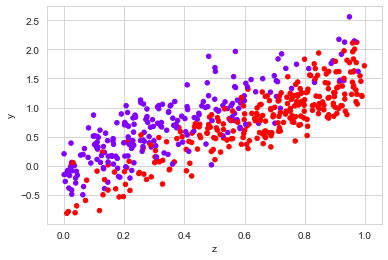

In [8]:
observed_data_1 = dg.generate_dataset_1()

observed_data_1.plot.scatter(x="z", y="y", c="x", cmap="rainbow", colorbar=False);

Before jumping into modelling the counterfactual, let's look at the data. If we look at how $Y$ is distributed, there appears to be a small difference between the two groups:

反事実のモデル化に入る前に、データを見てみましょう。$Y$がどのように分布しているかを見てみると、2つのグループの間には小さな違いがあるように見えます。

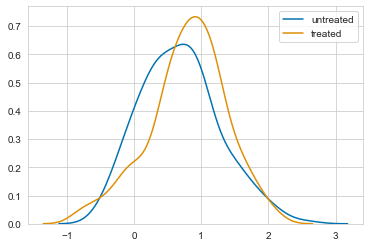

In [9]:
sns.kdeplot(observed_data_1.loc[lambda df: df.x == 0].y, label="untreated")
sns.kdeplot(observed_data_1.loc[lambda df: df.x == 1].y, label="treated")

We can confirm this by looking at the difference in means between the two groups

このことは、2つのグループ間の平均の差を見ることで確認することができます。

In [10]:
print("Observed ATE: {estimated_effect:.3f} ({standard_error:.3f})".format(**estimate_uplift(observed_data_1)))

Observed ATE: 0.113 (0.103)


However, if we look at the distribution of the covariance, $Z$, it is clear that there is a difference between the groups. 

しかし、共分散である$Z$の分布を見てみると、群間で差があることがわかります。

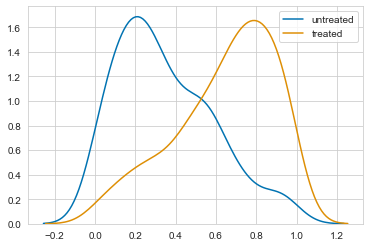

In [11]:
sns.kdeplot(observed_data_1.loc[lambda df: df.x == 0].z, label="untreated")
sns.kdeplot(observed_data_1.loc[lambda df: df.x == 1].z, label="treated")

If we believe that $Z$ has some infulance on the metric $Y$, this should concern us. We need some way to disentangle the effect of $X$ on $Y$ and the effect of $Z$ on $Y$.

もし $Z$ が $Y$ に何らかの影響を与えると考えるならば、このことは気になるところです。$X$が$Y$に与える影響と$Z$が$Y$に与える影響を区別する方法が必要です。

We can check the actually ATE using our simulated A/B test and confirm that it is difference of the observed value:

実際のATEをシミュレーションしたA/Bテストで確認し、それが観測値との差であることを確認することができます。

In [12]:
print("Real ATE:  {estimated_effect:.3f} ({standard_error:.3f})".format(**run_ab_test(dg.generate_dataset_1)))

Real ATE:  -0.479 (0.026)


But what happens if we cannot run this A/B test? We need to resort to modelling the system.

しかし、このA/Bテストを実行できない場合はどうなるのでしょうか？システムをモデル化する必要があります。

The simplest type of model we can use is a linear model. Specifically we could assume 

最も単純なタイプのモデルは線形モデルです。具体的には、次のように仮定します。

$Y_{0} = \alpha + \beta Z + \epsilon$

$Y_{1} = Y_{0} + \gamma$

If this is accurate, fitting the model

これが正確であれば、データをモデルにフィッティングさせて

$Y = \alpha + \beta Z + \gamma X$

to the data using linear regression will give us an estimate of the ATE.

を線形回帰を用いると、ATEの推定値が得られます。


The `causalinference` package gives us a simple interface to do this:

`causalinference` パッケージはこれを行うためのシンプルなインターフェースを提供してくれます。

In [13]:
from causalinference import CausalModel

cm = CausalModel(
    Y=observed_data_1.y.values, 
    D=observed_data_1.x.values, 
    X=observed_data_1.z.values)

cm.est_via_ols(adj=1)

print(cm.estimates)


Treatment Effect Estimates: OLS

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE     -0.488      0.032    -15.122      0.000     -0.551     -0.425



`causalinference` returns an estimate of the ATE, along with some statistical properties of the estimate. It is important to realise that the confidence intervals reported for the estimates are the confidence intervals _if we assume the model accurately describes the counterfactual_, not confidence intervals about how well the the model describes the counterfactual.

`causalinference` はATEの推定値と、その推定値の統計的性質を返します。推定値に対して報告された信頼区間は、モデルが正確に反事実を記述していると仮定した場合の信頼区間であり、モデルが反事実をどの程度よく記述しているかについての信頼区間ではないことを認識することが重要です。

In this case the package has done well in identifying the correct ATE - which is good, but the data generating process was specifically designed to meet the assumptions. Let's look at a few cases where it might fail.

このケースでは、パッケージは正しいATEを識別することに成功しています - これは良いことですが、データ生成プロセスは仮定を満たすように特別に設計されています。失敗する可能性のあるいくつかのケースを見てみましょう。

The first is when the effect is not simply additive:

最初のケースは、効果が単に相加的ではない場合です。

Observed ATE: 0.689 (0.104)
Real ATE:  0.563 (0.031)


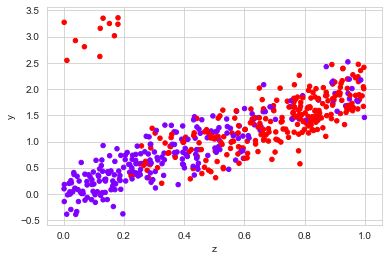

In [14]:
observed_data_2 = dg.generate_dataset_2()

observed_data_2.plot.scatter(x="z", y="y", c="x", cmap="rainbow", colorbar=False)

print("Observed ATE: {estimated_effect:.3f} ({standard_error:.3f})".format(**estimate_uplift(observed_data_2)))
print("Real ATE:  {estimated_effect:.3f} ({standard_error:.3f})".format(**run_ab_test(dg.generate_dataset_2)))

In [15]:
cm = CausalModel(
    Y=observed_data_2.y.values, 
    D=observed_data_2.x.values, 
    X=observed_data_2.z.values)

cm.est_via_ols(adj=1)

print(cm.estimates)


Treatment Effect Estimates: OLS

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE      0.246      0.088      2.805      0.005      0.074      0.419



Usually this can be overcome by using more powerful estimators . A simple, non-parametric approach, is the technique of [matching](https://en.wikipedia.org/wiki/Matching_%28statistics%29). The idea is to find for each sample which received the treatment, a similar samples which did not receive the treatment, and to directly compare these values. Exactly what you mean by "similar" will depend on your specific usecase., 

通常、これはより強力な推定量を使用することで克服することができます。シンプルでノンパラメトリックなアプローチは、[マッチング](https://en.wikipedia.org/wiki/Matching_%28statistics%29)の手法です。このアイデアは、処置を受けた各標本について、処置を受けなかった類似する標本を見つけ、これらの値を直接比較することです。「類似する」とは何を意味するのかは、あなたの特定の使用例に依存します。

The package `causalinference` implements matching by selecting for each unit, with replacement, the most similar unit from the other treatment group and using the difference between these two units to calculate the ATE. By default, the choice of match is chosen to be the nearest neighbour in covariate space $Z$, with the distances weighted by inverse variance of each dimension.

`causalinference` パッケージは、各ユニットについて、他の治療群から最も類似したユニットを置換で選択し、ATEを計算するためにこれら2つのユニット間の差を使用することで、マッチングを実装しています。デフォルトでは、マッチングの選択は、共変量空間$Z$において最近傍法を用いて選択され、距離は各次元の逆分散で重み付けされます。

There are options to change the number of units compared and the weighting of each dimension in the match. For more details, see the [documentation](http://laurence-wong.com/software/matching).

比較される単位の数や、一致における各次元の重み付けを変更するオプションがあります。詳細は、[ドキュメント](http://laurence-wong.com/software/matching)を参照してください。

We can compute the matching estimate with the following code
マッチング推定値は、以下のコードで計算できます。

In [16]:
cm = CausalModel(
    Y=observed_data_2.y.values, 
    D=observed_data_2.x.values, 
    X=observed_data_2.z.values)

cm.est_via_matching()

print(cm.estimates)


Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE      0.480      0.148      3.239      0.001      0.190      0.770
           ATC      0.973      0.142      6.854      0.000      0.695      1.251
           ATT      0.036      0.211      0.169      0.866     -0.379      0.450



The confidence intervals around our estimate now contain the true ATE.

推定値の信頼区間には、真のATEが含まれています。

# Covariate Imbalance
# 共変量の不均衡

A more difficult problem to deal with is when the covariates you are using are imbalanced: when there are areas of covariate space which contains only the treated or untreated samples. Here we have to extrapolate the effect of the treatment - which will depend heavily on assumptions model we use. 

対応するのがより困難な問題は，使用している共変量が不均衡な場合：共変量空間に，処理された標本または処理されていない標本のみを含む領域がある場合です。ここでは、治療の効果を外挿しなければなりません - これは、我々が使用する仮定モデルに大きく依存します。

The example below demonstrates this:

以下の例は、これを実証しています。

Observed ATE: 1.362 (0.080)
Real ATE:  2.449 (0.033)


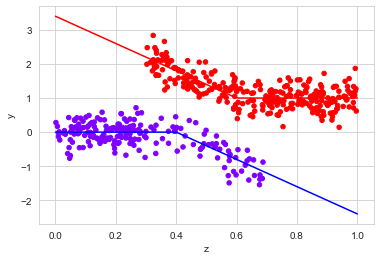

In [17]:
observed_data_3 = dg.generate_dataset_3()

observed_data_3.plot.scatter(x="z", y="y", c="x", cmap="rainbow", colorbar=False)

# actual response curves
z = np.linspace(0,1,100)
y0 =  np.where(z >= 0.4, -4*(z - 0.4), 0)
y1 =  np.where(z < 0.6,  -4*(z - 0.6), 0) + 1
plt.plot(z,y0, "b")
plt.plot(z,y1, "r")


print("Observed ATE: {estimated_effect:.3f} ({standard_error:.3f})".format(**estimate_uplift(observed_data_3)))
print("Real ATE:  {estimated_effect:.3f} ({standard_error:.3f})".format(**run_ab_test(dg.generate_dataset_3)))

In [18]:
# OLS estimator
cm = CausalModel(
    Y=observed_data_3.y.values, 
    D=observed_data_3.x.values, 
    X=observed_data_3.z.values)

cm.est_via_ols()

print(cm.estimates)


Treatment Effect Estimates: OLS

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE      1.969      0.055     35.707      0.000      1.861      2.078
           ATC      1.971      0.056     35.117      0.000      1.861      2.081
           ATT      1.968      0.073     26.923      0.000      1.825      2.112



In [19]:
# Matching estimator
cm = CausalModel(
    Y=observed_data_3.y.values, 
    D=observed_data_3.x.values, 
    X=observed_data_3.z.values)

cm.est_via_matching()

print(cm.estimates)


Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE      1.913      0.156     12.269      0.000      1.607      2.218
           ATC      1.965      0.277      7.093      0.000      1.422      2.509
           ATT      1.876      0.177     10.626      0.000      1.530      2.222



The OLS estimator fails to capture the true effect, and while the matching estimator improves things a bit, there just isn't enough information in the data to extrapolate fully into areas where there isn't overlap.

OLS推定量では真の効果を捉えることができず、マッチング推定量では少し改善されますが、重なりがない領域に完全に外挿するにはデータ内に十分な情報がないだけです。

This example might seem contrived - that's because it is, but once we start looking covariates with higher dimensionality this issue can become much more common.

この例は矛盾しているように見えるかもしれませんが、一度高次元の共変量を見始めると、この問題はもっと一般的になります。

`causalinference` provides a useful tool to quickly assess the overlap of the variables using the `summary_stats` property:

`causalinference` は、`summary_stats` プロパティを用いて変数の重複を素早く評価するための便利なツールを提供します。

In [20]:
print(cm.summary_stats)


Summary Statistics

                       Controls (N_c=206)         Treated (N_t=294)             
       Variable         Mean         S.d.         Mean         S.d.     Raw-diff
--------------------------------------------------------------------------------
              Y       -0.151        0.438        1.210        0.467        1.362

                       Controls (N_c=206)         Treated (N_t=294)             
       Variable         Mean         S.d.         Mean         S.d.     Nor-diff
--------------------------------------------------------------------------------
             X0        0.267        0.185        0.681        0.205        2.116



Where the Normalized difference is defined as

ここで、正規化された差は次のように定義されます。

$\frac{\bar{X}_{T} - \bar{X}_{T}}{ (\sigma^{2}_{T} + \sigma^{2}_{C})/2 } $

While it isn't a strict statistical test, it provides some indication how much overlap there is between each covariate. Values greater than one suggest there isn't much overlap.

これは厳密な統計的検定ではありませんが、各共変量の間にどれだけの重複があるかを示すいくつかの指標を提供します。1より大きい値は、あまり重複がないことを示唆しています。

# Propensity Score
# 傾向スコア

The Propensity score is a estimate of how likely it is for a subject to have ended up with the treatment, given the covariates:

傾向スコアは、共変量が与えられている場合に、対象が処置を受けることになった可能性がどれだけ高いかの推定値です。

$\hat{p}(Z) = P(X|Z)$

We can estimate this however we like, but once we have it there are a number of things we can do with it.

これは好きなように推定することができますが、一旦推定してしまえば、いくつかのことができるようになります。

## Inverse Propensity Score Weighting
## 逆傾向スコアの重み付け

Remember that the problem of measuring causal inference is that we want to know the quantity $E[Y_{i}]$, but we only have access to samples from $E[Y_{i}|X=i]$.

因果推論の測定の問題は、量 $E[Y_{i}]$ を知りたいのですが、 $E[Y_{i}|X=i]$ の標本にしかアクセスできないことを覚えておいてください。

The probability of a potential outcome can be expanded to give

ポテンシャル・アウトカムの確率は、次のように拡張することができます。

$P(Y_{i}) = P(Y_{i}| X = i)P(X = i)$

This suggests that we can estimate the true

このことは、真の 

$E[Y_{i}] = E[\frac{Y_{i}}{P(X=i|Z)}P(X=i|Z)] = E[\frac{Y_{i}}{P(X=i|Z)}|X=i, Z]$

を推定することができることを示唆しています。

So if we weight each point by it's inverse propensity, we can recover the potential outcomes. The result is the [inverse propensity score weight estimator](https://en.wikipedia.org/wiki/Inverse_probability_weighting):

そこで、各点に逆傾向スコアで重みを付ければ、潜在的な結果を回収することができます。その結果が [逆傾向スコア重み推定法] (https://en.wikipedia.org/wiki/Inverse_probability_weighting) です。

$\Delta_{IPS} = \frac{1}{N}\left(\sum_{i \in 1} \frac{y_{i}}{\hat{p}(z_{i})} - \sum_{i \in 0} \frac{y_{i}}{1 - \hat{p}(z_{i})}\right)$

Let's see how it does one of our previous datasets:

以前のデータセットの一つをどうするか見てみましょう。

Observed ATE: 0.147 (0.102)
Real ATE:  -0.490 (0.025)


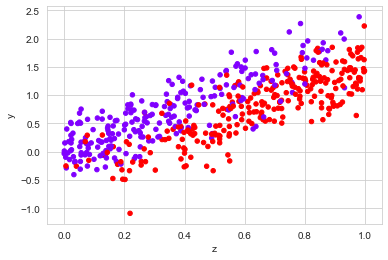

In [21]:
observed_data_1 = dg.generate_dataset_1()

observed_data_1.plot.scatter(x="z", y="y", c="x", cmap="rainbow", colorbar=False)

print("Observed ATE: {estimated_effect:.3f} ({standard_error:.3f})".format(**estimate_uplift(observed_data_1)))
print("Real ATE:  {estimated_effect:.3f} ({standard_error:.3f})".format(**run_ab_test(dg.generate_dataset_1)))

We can estimate the propensity using the `CausalInference` package's methods `est_propensity_s` or `est_propensity`, which uses logistic regression on the covariate to estimate propensity:

`CausalInference`パッケージのメソッド `est_propensity_s` や `est_propensity` を用いると、共変量に対するロジスティック回帰を用いて傾向を推定することができます。

In [22]:
cm = CausalModel(
    Y=observed_data_1.y.values, 
    D=observed_data_1.x.values, 
    X=observed_data_1.z.values)

cm.est_propensity_s()

propensity = cm.propensity["fitted"]

df = observed_data_1

df["ips"] = np.where(
    df.x == 1, 
    1 / propensity,
    1 / (1 - propensity))
df["ipsw"] = df.y * df.ips

ipse = (
      df[df.x == 1]["ipsw"].sum() 
    - df[df.x == 0]["ipsw"].sum()
) / df.shape[0]

ipse

-0.4613297031604915

This does well in our situation - by is very dependent on how good our estimate of the propensity score is - for the data generator we're using for this example the relationship can be described well by plain logistic regression. If we tried to estimate the propensity using, say, `sklean's` logistic regression function, which by default uses regularization, we would have got the wrong answer:

この例で使用しているデータ生成器では、単純なロジスティック回帰で関係をうまく記述することができます。この例で使用しているデータ生成器では、関係性は単純なロジスティック回帰で十分に記述できますが、もし我々が`skleanの`ロジスティック回帰関数（デフォルトでは正則化が使用されています）を使用して傾向スコアを推定しようとした場合、間違った答えが得られるでしょう。

In [23]:

from sklearn.linear_model import LogisticRegression

lg = LogisticRegression()
X = df.z.values.reshape(-1,1)
y = df.x.values
lg.fit(X,y)

propensity = lg.predict_proba(X)[:,1]

df["ips"] = np.where(
    df.x == 1, 
    1 / propensity,
    1 / (1 - propensity))
df["ipsw"] = df.y * df.ips

ipse = (
      df[df.x == 1]["ipsw"].sum() 
    - df[df.x == 0]["ipsw"].sum()
) / df.shape[0]

ipse

-0.3291860760196773

It does better than our naive estimator, but is not correct.

我々の素朴な推定値よりは良いですが、正しくありません。

# Doubly Robust Weighted Estimator
# 頑健な重み付き推定器

We can combine the inverse propensity score weighting estimators and the linear estimator of effect size together to try and reduce the flaws in either model. This is done by preforming weighted linear regression on the data, with each point weighted by the inverse propensity score. The result is the [doubly robust weighted estimator](https://academic.oup.com/aje/article/173/7/761/103691). 

このように、逆傾向スコアの重み付け推定量と効果量の線形推定量を組み合わせて、どちらかのモデルの欠陥を減らしてみることができます。これは、各ポイントを逆傾向スコアで重み付けした状態で、データに重み付き線形回帰を事前に実行することで行われます。その結果が[doubly robust weighted estimator](https://academic.oup.com/aje/article/173/7/761/103691)です。

The idea is that points because there is an bias in which samples are treated in the observational data, the samples which were treated, but were unlikely to have been, are more import and should be given more weight.

考え方としては、観測データの中でどの標本が処置されているかにバイアスがあるので、標本の中でも処置されたが、処置される可能性が低かった標本の方がより重要で、より多くの重みを与えるべきだという点です。

We can apply it using the following:

これを応用するには、以下のような方法があります。

Observed ATE: 0.145 (0.106)
Real ATE:  -0.494 (0.026)


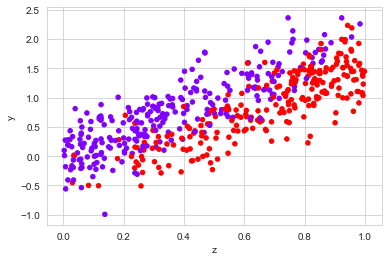

In [24]:
observed_data_1 = dg.generate_dataset_1()

observed_data_1.plot.scatter(x="z", y="y", c="x", cmap="rainbow", colorbar=False)

print("Observed ATE: {estimated_effect:.3f} ({standard_error:.3f})".format(**estimate_uplift(observed_data_1)))
print("Real ATE:  {estimated_effect:.3f} ({standard_error:.3f})".format(**run_ab_test(dg.generate_dataset_1)))

In [25]:
cm = CausalModel(
    Y=observed_data_1.y.values, 
    D=observed_data_1.x.values, 
    X=observed_data_1.z.values)

cm.est_propensity_s()
cm.est_via_weighting()

print(cm.estimates)


Treatment Effect Estimates: Weighting

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE     -0.521      0.034    -15.344      0.000     -0.588     -0.455



In [26]:
cm.estimates

{'weighting': {'ate': -0.5214252844257842, 'ate_se': 0.03398288940994425}}

# Unconfoundedness and the Propensity Score 
# 非交絡性と傾向スコア 

In the previous sections, we assumed that the outcomes and the treatment were independent given our covariates:

前のセクションでは、共変量が与えられているので、結果と処置は独立していると仮定しました。

$Y_{1}, Y_{0} \ci X \, | \,Z$

We can also assume something slightly stronger: that the outcomes are independent of the treatment, conditioned on the probability of the propensity:

また、もう少し強い仮定もできます。それは、結果が処置とは無関係で、傾向の確率を条件にしているということです。

$Y_{1}, Y_{0} \ci X \, | \,\hat{p}(Z)$

With this assumption, we potentially reduce the dimensionality of the conf# 根拠の無さと傾向スコア ounding variables. This allows us to perform several techniques which may not work in higher dimensional settings. 

この仮定では、交絡変数の次元を減らすことができます。これは、高次元の設定では機能しないかもしれないいくつかの手法を実行することを可能にします。

# Trimming
# トリミング

We previously saw that imbalances in covariates can create issues. A simple solution is to only make predictions for the counterfactual in regions where there is a good overlap, or "trim" points where there is not good overlap. For high dimensional data "good overlap" can be difficult to define - using just the propensity score to define overlap is one way to solve this. 

共変量の不均衡が問題を引き起こすことがあることをこれまでに確認しました。簡単な解決策は、良いオーバーラップがある領域でのみ反事実の予測を行うか、または良いオーバーラップがない点を "トリム "することです。高次元データの場合、"良いオーバーラップ "を定義するのは難しいかもしれません - オーバーラップを定義するために傾向スコアを使用することは、これを解決する1つの方法です。


Let's look at a dataset with low overlap:

オーバーラップの少ないデータセットを見てみましょう。

Observed ATE: 1.361 (0.080)
Real ATE:  2.437 (0.033)


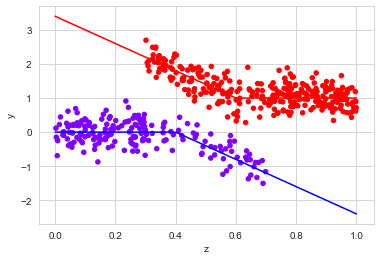

In [27]:
observed_data_3 = dg.generate_dataset_3()

observed_data_3.plot.scatter(x="z", y="y", c="x", cmap="rainbow", colorbar=False)

# actual response curves
z = np.linspace(0,1,100)
y0 =  np.where(z >= 0.4, -4*(z - 0.4), 0)
y1 =  np.where(z < 0.6,  -4*(z - 0.6), 0) + 1
plt.plot(z,y0, "b")
plt.plot(z,y1, "r")


print("Observed ATE: {estimated_effect:.3f} ({standard_error:.3f})".format(**estimate_uplift(observed_data_3)))
print("Real ATE:  {estimated_effect:.3f} ({standard_error:.3f})".format(**run_ab_test(dg.generate_dataset_3)))

`CausalInference` offers a method to trim the data based on the propensity score

`CausalInference`は、傾向スコアに基づいてデータをトリミングする方法を提供しています。

In [28]:
# OLS estimator
cm = CausalModel(
    Y=observed_data_3.y.values, 
    D=observed_data_3.x.values, 
    X=observed_data_3.z.values)

cm.est_propensity_s()
cm.trim_s()
cm.est_via_matching()

print(cm.estimates)


Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE      2.068      0.127     16.350      0.000      1.820      2.316
           ATC      2.249      0.229      9.843      0.000      1.802      2.697
           ATT      1.920      0.102     18.739      0.000      1.719      2.121



We can look at the remaining data in the following way

残りのデータを次のように見ることができます。

Observed ATE: 1.708 (0.125)
Real ATE:  1.984 (0.031)


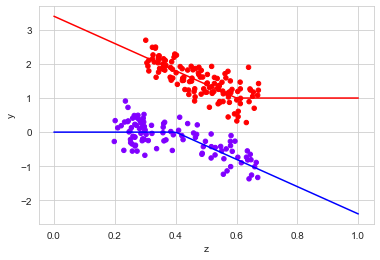

In [29]:
# mask out data ignored by the 
propensity = cm.propensity["fitted"]
cutoff = cm.cutoff
mask = (propensity > cutoff) &  (propensity < 1 - cutoff)

# plot the data
observed_data_3[mask].plot.scatter(x="z", y="y", c="x", cmap="rainbow", colorbar=False)

# actual response curves
z = np.linspace(0,1,100)
y0 =  np.where(z >= 0.4, -4*(z - 0.4), 0)
y1 =  np.where(z < 0.6,  -4*(z - 0.6), 0) + 1
plt.plot(z,y0, "b")
plt.plot(z,y1, "r")

# filter out data in regions we have trimmed when we calculate the true uplift
filter_ = lambda df: (df.z > 0.2) & (df.z < 0.7)

print("Observed ATE: {estimated_effect:.3f} ({standard_error:.3f})".format(**estimate_uplift(observed_data_3[mask])))
print("Real ATE:  {estimated_effect:.3f} ({standard_error:.3f})".format(
    **run_ab_test(dg.generate_dataset_3, filter_= filter_)))

It does quite well in there cases.

これは、そのような場合にはかなりうまくいきます。

When we apply trimming, we are explicitly saying that it is only possible to make causal inferences for samples in some part of the covariate space. For samples outside these regions, we cannot say anything about the ATE.

トリミングを適用するとき、共変量空間の一部のサンプルについてのみ因果推論を行うことが可能であることを明示的に述べています。これらの領域外の標本について、ATEについては何も言えません。

# Stratification
# 層化


Another use of the propensity score is the stratification, or blocking, estimator. It consist of grouping the data points into groups of similar propensity, and to estimate the ATE within these groups. Again, `CausalInference` provides a nice interface to achieve this. 
`stratify`(ユーザー定義のスタータ境界の場合)または`stratify_s`(境界を自動的に選択する場合)メソッドを使用して、層を決定します。
傾向スコアのもう一つの利用法は、層別化（ブロッキング）推定法である。これは、データポイントを類似の傾向を持つグループにグループ化し、これらのグループ内のATEを推定することからなる。ここでも、`CausalInference`はこれを実現するためのインタフェースを提供している。

We use the `stratify` (for user defined stata boundaries) or `stratify_s` (to automatically choose the boundaries) methods to determine the strata:

`stratify`(ユーザー定義のスタータ境界の場合)または`stratify_s`(境界を自動的に選択する場合)メソッドを使用して、層を決定します。

In [30]:
observed_data_1 = dg.generate_dataset_1()

cm = CausalModel(
    Y=observed_data_1.y.values, 
    D=observed_data_1.x.values, 
    X=observed_data_1.z.values)

cm.est_propensity_s()
cm.stratify_s()

print(cm.strata)


Stratification Summary

              Propensity Score         Sample Size     Ave. Propensity   Outcome
   Stratum      Min.      Max.  Controls   Treated  Controls   Treated  Raw-diff
--------------------------------------------------------------------------------
         1     0.093     0.260       108        18     0.163     0.182    -0.544
         2     0.266     0.327        23         9     0.296     0.292    -0.639
         3     0.327     0.411        14        17     0.368     0.376    -0.441
         4     0.412     0.555        31        31     0.473     0.490    -0.428
         5     0.557     0.769        45        80     0.661     0.667    -0.499
         6     0.770     0.910        18       106     0.838     0.859    -0.536



and the `est_via_blocking` method to combine the estimates of these strata into one overall ATE:

そして `est_via_blocking` メソッドを用いて、これらの層の推定値を1つの全体的なATEに結合します。

In [31]:
cm.est_via_blocking()
print(cm.estimates)


Treatment Effect Estimates: Blocking

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE     -0.559      0.033    -16.722      0.000     -0.625     -0.494
           ATC     -0.571      0.039    -14.797      0.000     -0.646     -0.495
           ATT     -0.548      0.038    -14.304      0.000     -0.624     -0.473



Which again works well.

これもよく機能します。

Stratify the data into groups by propensity score is useful when we don't have any prior knowledge of what constitutes "similar" units, however it is not the only way. If you have prior knowledge the different groups of your samples are likely to be affected by the intervention in similar ways, it makes sense to split you samples into these groups before estimating the ATE, then pooling the results to get a global ATE. 

傾向スコアによってデータをグループに層別化することは、何が「類似した」単位を構成するかについて予備知識がない場合に有用ですが、それだけが唯一の方法ではありません。標本の異なるグループが類似した方法で介入の影響を受ける可能性が高いことを事前に知っている場合は、ATEを推定する前にサンプルをこれらのグループに分割し、結果をプールしてグローバルなATEを取得することは理にかなっています。

# Which Technique to Use?
# どの手法を使うか？


I've now covered most the of the common techniques for causal inference from observational data. The remaining question is how to decide which method to use? This is not an easy question. While there are some automated techniques, like [this paper](https://arxiv.org/pdf/1711.00083.pdf), I haven't had a change to try them out. 

これで、観測データからの因果推論のための一般的な手法のほとんどをカバーしました。残りの問題は「どのように、どの方法を使用するかを決定するか？」です。これは簡単な質問ではありません。[この論文](https://arxiv.org/pdf/1711.00083.pdf)のような自動化された手法もありますが、私はそれらを試してみたことがありません。


Ultimately, to choose your technique you need to make some assumptions about how you contruct you counter factual. If you trust you data to have good over in covariate space, matching is a good approach because there is always some nearby point with the opposite treatment. When this isn't the case, you need to either use a model you trust to extrapolate well into unexplored areas or make the assumption that something like the propensity score captures enough information to assume ignorability.

最終的には、あなたのテクニックを選択するためには、あなたがどのように反事実を構築するかについていくつかの仮定をする必要があります。共変量空間での重なりが良好であるとデータを信頼しているならば、マッチングは良いアプローチです。これがそうでない場合は、未踏の領域にうまく外挿するために信頼できるモデルを使用するか、傾向スコアのようなものが無視可能性を仮定するのに十分な情報を捉えるという仮定を立てる必要があります。

To highlight that all these methods can fail, I have one more example. Unlike the previous examples, there is more than one covariate. Like all the previous datagenerators, this one also obeys the assumption 

これらの方法がすべて失敗する可能性があることを強調するために、もう一つ例を挙げます。前の例とは異なり、共変量は1つ以上ある。これまでのすべてのデータ・ジェネレーターと同様に、このデータ・ジェネレーターもまた、設計上以下の仮定に従います。

$Y_{1}, Y_{0} \ci X \, | \,Z$

By design. 


Let's blindly try the methods we've discussed so far and see what happens

これまで議論してきた方法を盲目的に試して、どうなるか見てみましょう。

In [32]:
data_gen = dg.generate_exercise_dataset_2
ds = data_gen()

print("Observed ATE: {estimated_effect:.3f} ({standard_error:.3f})".format(**estimate_uplift(ds)))
print("Real ATE:  {estimated_effect:.3f} ({standard_error:.3f})".format(**run_ab_test(data_gen)))

zs = [c for c in ds.columns if c.startswith("z")]

cm = CausalModel(
    Y=ds.y.values, 
    D=ds.x.values, 
    X=ds[zs].values)

cm.est_via_ols()
cm.est_via_matching()
cm.est_propensity_s()
cm.est_via_weighting()

cm.stratify_s()
cm.est_via_blocking()

print(cm.estimates)

Observed ATE: -0.423 (0.711)
Real ATE:  4.570 (0.184)

Treatment Effect Estimates: OLS

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE     -0.165      0.363     -0.455      0.649     -0.878      0.547
           ATC      0.438      0.402      1.088      0.276     -0.350      1.226
           ATT     -0.468      0.384     -1.218      0.223     -1.220      0.285

Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE      1.241      0.581      2.137      0.033      0.103      2.379
           ATC      1.314      0.695      1.890      0.059     -0.049      2.677
           ATT      1.204      0.667      1.804      0.071     -0.104      2.512

Treatment Effect Estimates: Weighting

                     Es

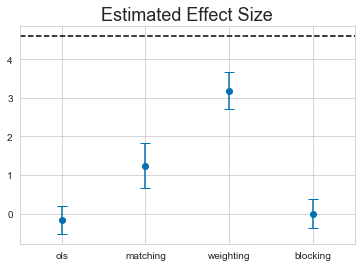

In [33]:
y = []
yerr = []
x_label = []

for method, result in dict(cm.estimates).items():
    y.append(result["ate"])
    yerr.append(result["ate_se"])
    x_label.append(method)
    
x = np.arange(len(y))

plt.errorbar(x=x, y=y, yerr=yerr, linestyle="none", capsize=5, marker="o")
plt.xticks(x, x_label)
plt.title("Estimated Effect Size", fontsize=18)
plt.hlines(4.6, -0.5, 3.5, linestyles="dashed")
plt.xlim(-0.5,3.5);

The horizontal dashed line shows the true ATE for this dataset.

横の破線は、このデータセットの真のATEを示しています。

Not only do we have a range of different results from each technique, they all miss the true value. 

それぞれの手法の結果が異なるだけでなく、すべての手法が真の値を見逃しています。

This should be a warning about the limitations of this kind of technique. It might be an intesteresting exercise for the reader to try and work about what properties of the dataset cause these methods to miss the true value.

これは、この種の手法の限界についての警告であるべきです。データセットのどのような性質が、これらの手法が真の値を外れる原因となっているのか、読者が試してみるのは、非常に興味深い練習になるかもしれません。

# The Structure of Causal Inference
# 因果推論の構造

Hopefully by this point, you will have realised the importance of the ignorability assumption

願わくば、この時点までに、あなたは無視可能性仮定の重要性に気付いているでしょう。

$Y_{1}, Y_{0} \ci X \, | \,Z$

What I haven't talked about is how we choose $Z$ so that this is true. Ultimately this needs to come from domain knowledge about the system being studied. There are a set of powerful tools called [Causal Graphical Models](https://en.wikipedia.org/wiki/Causal_graph) which allow you to encode knowledge about the system being studied is a graphical model of the system and to reason about conditional independence assumptions like the one above.

これまで話してこなかったのは、これが真実であるように、どのようにして$Z$を選択するかということです。最終的には、研究されているシステムに関する領域の知識から来る必要があります。[因果関係モデル](https://en.wikipedia.org/wiki/Causal_graph)と呼ばれる強力なツールのセットがあります。これを使えば、研究しているシステムに関する知識をシステムのグラフィカルモデルとしてエンコードしたり、上記のような条件付き独立性の仮定について推論したりすることができます。

[I discuss these my next post on causal inference](http://www.degeneratestate.org/posts/2018/Jul/10/causal-inference-with-python-part-2-causal-graphical-models/).

[因果推論の次の投稿では、これらについて議論します。](http://www.degeneratestate.org/posts/2018/Jul/10/causal-inference-with-python-part-2-causal-graphical-models/)

Another question this post might raise is whether the only way to make causal inferences is through adjusting for confounding variables. It isn't - in a [later post](http://www.degeneratestate.org/posts/2018/Sep/03/causal-inference-with-python-part-3-frontdoor-adjustment/) I look at another technique you can use.

この投稿が提起するもう一つの疑問は、因果推論を行う唯一の方法は交絡変数を調整することであるかどうかということです。そうではありません - [後の投稿](http://www.degeneratestate.org/posts/2018/Sep/03/causal-inference-with-python-part-3-frontdoor-adjustment/)では 他にも使えるテクニックを見てみます。

# Code
# コード

You can find the notebook for this post on github [here](https://github.com/ijmbarr/notes-on-causal-inference).

この投稿のノートはgithub [こちら](https://github.com/ijmbarr/notes-on-causal-inference)にあります。